In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

In [2]:
layer_num=3
hidden_num=64
sym='no_symetry'

dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [3]:
def potential(x,k):
    poten=1/2*k*x**2
    return poten

def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [50]:
en_num = 10
La=-24
Lb= 24
L=Lb-La  # domain length
N = 6000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)

l=0
k = 4
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

model=Mynetwork().to(device=device,dtype=dtype)

loss_fn=nn.MSELoss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap
T = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)

In [53]:
real_en=energy(en_num,k,m,h_bar,device,dtype)

In [51]:
V_real_poten=potential(grid,k)
A = T + torch.diag(V_real_poten.flatten())
eigenvalues, eigenvectors  = torch.linalg.eigh(A)

In [54]:
torch.abs(real_en - eigenvalues[:en_num]).max(), torch.abs(real_en - eigenvalues[:en_num]).mean()

(tensor(0.0008, device='cuda:2'), tensor(0.0004, device='cuda:2'))

In [21]:
torch.mm(A, eigenvectors[:10].transpose(1,0))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-3.6593e-01,  1.0120e+00, -2.2146e+00,  ...,  2.5571e+01,
         -3.5300e+01,  4.7154e+01],
        [ 1.6533e+02, -3.2986e+02,  4.9281e+02,  ..., -1.2601e+03,
          1.4000e+03, -1.5341e+03],
        [-7.6997e+01,  1.5362e+02, -2.2951e+02,  ...,  5.8687e+02,
         -6.5199e+02,  7.1446e+02]], device='cuda:2')

In [37]:
eigenvectors[0][1004]

tensor(-0.0082, device='cuda:2')

In [32]:
grid[1000]

tensor([-15.9933], device='cuda:2')

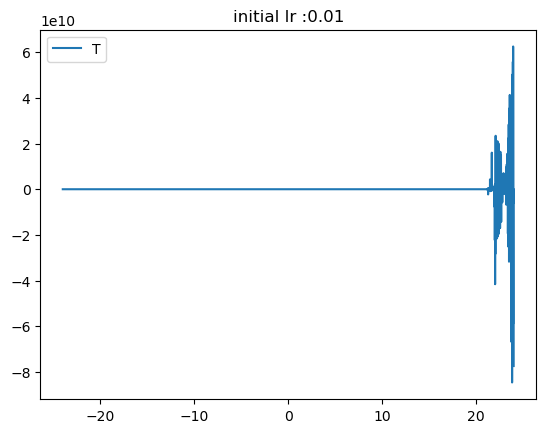

In [48]:
# V_for_contrast=torch.load(f'./V_NN_30_La-10_Lb10_N2000.pth',map_location=device)
# V_for_contrast=V_for_contrast.cpu().detach().numpy()

real_poten=potential(grid.cpu().detach().numpy(),k)
# plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),((A@eigenvectors[10])/(eigenvectors[10]+1e-8)).cpu().detach().numpy(),label='T')
# plt.plot(grid.cpu().detach().numpy(),eigenvectors[9].cpu().detach().numpy(),label='0')
plt.title(f'initial lr :{0.01}')
# plt.plot(grid.cpu().detach().numpy(),V_for_contrast,label='contrast')
plt.legend()
plt.show()

/tmp/ipykernel_716695/1666276743.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/m

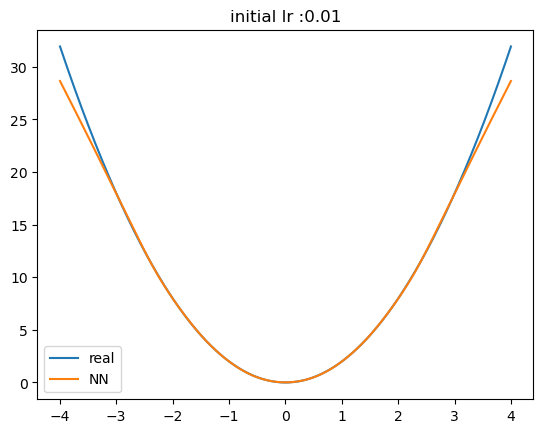

In [ ]:
# V_for_contrast=torch.load(f'./V_NN_30_La-10_Lb10_N2000.pth',map_location=device)

V_NN=V_NN.cpu().detach().numpy()
# V_for_contrast=V_for_contrast.cpu().detach().numpy()

real_poten=potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy()[2500:3500],real_poten[2500:3500],label='real')
plt.plot(grid.cpu().detach().numpy()[2500:3500],V_NN[2500:3500],label='NN')
plt.title(f'initial lr :{0.01}')
# plt.plot(grid.cpu().detach().numpy(),V_for_contrast,label='contrast')
plt.legend()
plt.show()

In [20]:
grid.shape

torch.Size([6000, 1])

In [6]:
real_en=energy(en_num,k,m,h_bar,device,dtype)

In [7]:
real_en

tensor([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.], device='cuda:2')

In [ ]:
model.load_state_dict(torch.load(f'./pre_train.pth'))

V_diag=model(grid)

A = T + torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]
val_loss=loss_fn(output,real_en)


/tmp/ipykernel_716695/170942699.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./pre_train.pth'))


In [11]:
output

tensor([ 0.9993,  2.9992,  5.0001,  6.9982,  9.0011, 10.9971, 13.0001, 14.9982,
        16.9983, 18.9979], device='cuda:2', grad_fn=<SliceBackward0>)